# Load required libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
from scipy import stats
%matplotlib inline

In [2]:
df = pd.read_csv('data/QVI_dataframe',index_col=['DATE'], parse_dates=['DATE']).sort_index()
df.head(3)

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,SIZE,BRAND
DATE,,,,,,,,,,,
2018-07-01,229,229079,230838,77,Doritos Corn Chips Nacho Cheese 170g,2,8.8,OLDER SINGLES/COUPLES,Budget,170,Doritos
2018-07-01,21,21037,17576,62,Pringles Mystery Flavour 134g,2,7.4,RETIREES,Mainstream,134,Pringles
2018-07-01,40,40204,37044,81,Pringles Original Crisps 134g,2,7.4,YOUNG FAMILIES,Budget,134,Pringles


Creating month and year column.

In [3]:
df['month'] = df.index.month
df['year'] = df.index.year
df['year-month'] = df.index.to_period('M')

# Selecting control stores

The client has selected store numbers 77, 86 and 88 as trial stores and wants control stores to be established from stores that are operational for the entire observation period. The trial period goes from Feb 2019 to Apr 2019.

Creating separete dataframe for trial period and test period.

In [4]:
pre_trial_df, trial_df = df['2018-07':'2019-01'], df['2019-02':'2019-04']

Separating trial stores selected by client.

In [5]:
trial = pre_trial_df.query('STORE_NBR == 77 or STORE_NBR == 86 or STORE_NBR == 88')

Creating dataframe with the possible control stores to be selected and removing stores that don't have full observation periods.

In [6]:
possible_control = pd.concat([pre_trial_df, trial, trial]).drop_duplicates(keep=False)

In [7]:
possible_control['month'] = possible_control.index.month
possible_control['year'] = possible_control.index.year

Calculating some metrics to help with the selection of similiar stores to the selected stores.

##### Monthly overall sales revenue

In [8]:
monthly_sales_revenue_possible = possible_control.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum')
monthly_sales_revenue_trial = trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum')
monthly_sales_revenue_possible.dropna(inplace=True)
monthly_sales_revenue_possible.head()

year         2018                                             2019
month          7        8       9       10      11      12      1 
STORE_NBR                                                         
1           188.9   168.40   268.1   175.4   184.8   160.6   149.7
2           140.5   180.90   133.9   160.1   143.3   129.2   158.7
3          1164.9   998.15  1011.3  1017.5   936.6  1075.7   980.3
4          1318.3  1188.10  1168.0  1275.0  1089.6  1134.6  1402.6
5           763.8   654.50   875.2   740.6   707.0   800.2   772.6

##### Monthly number of customers

In [9]:
monthly_num_customers_possible = possible_control.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique)
monthly_num_customers_trial = trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique)
monthly_num_customers_possible.dropna(inplace=True)
monthly_num_customers_possible.head()

year        2018                                      2019
month         7      8      9      10     11     12     1 
STORE_NBR                                                 
1           47.0   41.0   57.0   39.0   44.0   37.0   35.0
2           36.0   35.0   32.0   39.0   33.0   32.0   41.0
3          108.0  106.0  102.0  103.0   95.0  107.0   97.0
4          121.0  118.0  117.0  119.0  109.0  102.0  125.0
5           86.0   85.0   99.0   81.0   80.0   90.0   84.0

Creating function to compare any store to the trial stores.

In [10]:
def correlation_total(possible):
    '''(Series)->list
    Returns a dict with correlation between the 3 trial stores and the total revenue per month.
    '''    
    corr_dict = {}
    for i in range(3):
        corr_dict[monthly_sales_revenue_trial.index[i]] = monthly_sales_revenue_trial.iloc[i].corr(possible)
            
    return corr_dict

In [11]:
def correlation_num_cust(possible):
    '''(Series)->list
    Returns a dic with correlation between the 3 trial stores and the number of customers per month.
    '''
    corr_dict = {}
    for i in range(3):
        corr_dict[monthly_num_customers_trial.index[i]] = monthly_num_customers_trial.iloc[i].corr(possible)        
    
    return corr_dict

Creating dataframes using the functions created, where each row represents a store being compared to the 3 trial stores selected by the client and averaging the created dataframes.

In [12]:
data_corr_total = [correlation_total(monthly_sales_revenue_possible.loc[i]) for i in monthly_sales_revenue_possible.index]
data_corr_cust = [correlation_num_cust(monthly_num_customers_possible.loc[i]) for i in monthly_num_customers_possible.index]
df_corr_total = pd.DataFrame(data_corr_total,index=monthly_sales_revenue_possible.index).abs()
df_corr_cust = pd.DataFrame(data_corr_cust,index=monthly_num_customers_possible.index).abs()
avg = (df_corr_total + df_corr_cust)/2
avg.head()

,77,86,88
STORE_NBR,,,
1,0.171624,0.374556,0.636105
2,0.423837,0.295438,0.389947
3,0.707848,0.101784,0.450705
4,0.326629,0.020930,0.361454
5,0.181908,0.273139,0.182530


Getting the highest correlated stores from the averaged dataframe.

In [13]:
for i in [77,86,88]:
    print('Store with highest average correlation with store {}: {}'.format(
        i,avg[i].sort_values(ascending=False).index[0]))

Store with highest average correlation with store 77: 233
Store with highest average correlation with store 86: 155
Store with highest average correlation with store 88: 14


# Comparing selected control stores with trial stores

We'll start by defining some functions that will help with scaling the control store's sales so as to control for any differences between the two stores outside of the trial period.

In [14]:
# Scaling constants 
scaling_sales_77_233 = pre_trial_df.query('STORE_NBR == 77')['TOT_SALES'].sum() / pre_trial_df.query('STORE_NBR == 233')['TOT_SALES'].sum()
scaling_sales_86_155 = pre_trial_df.query('STORE_NBR == 86')['TOT_SALES'].sum() / pre_trial_df.query('STORE_NBR == 155')['TOT_SALES'].sum()
scaling_sales_88_14 = pre_trial_df.query('STORE_NBR == 88')['TOT_SALES'].sum() / pre_trial_df.query('STORE_NBR == 14')['TOT_SALES'].sum()

scaling_num_cust_77_233 = pre_trial_df.query('STORE_NBR == 77')['LYLTY_CARD_NBR'].nunique() / pre_trial_df.query('STORE_NBR == 233')['LYLTY_CARD_NBR'].nunique()
scaling_num_cust_86_155 = pre_trial_df.query('STORE_NBR == 86')['LYLTY_CARD_NBR'].nunique() / pre_trial_df.query('STORE_NBR == 155')['LYLTY_CARD_NBR'].nunique()
scaling_num_cust_88_14 = pre_trial_df.query('STORE_NBR == 88')['LYLTY_CARD_NBR'].nunique() / pre_trial_df.query('STORE_NBR == 14')['LYLTY_CARD_NBR'].nunique()

In [15]:
def scale_total_sales(x):
    if x['STORE_NBR'] == 233:
        return x['TOT_SALES']*scaling_sales_77_233
    elif x['STORE_NBR'] == 155:
        return x['TOT_SALES']*scaling_sales_86_155
    elif x['STORE_NBR'] == 14:
        return x['TOT_SALES']*scaling_sales_88_14
    else:
        return x['TOT_SALES']

In [16]:
def scale_num_cust(x):
    if x['STORE_NBR'] == 233:
        return x['TOT_SALES']*scaling_num_cust_77_233
    elif x['STORE_NBR'] == 155:
        return x['TOT_SALES']*scaling_num_cust_86_155
    elif x['STORE_NBR'] == 14:
        return x['TOT_SALES']*scaling_num_cust_88_14
    else:
        return x['TOT_SALES']

## Store 77 and Store 233

####  Comparing total sales

In [17]:
scaled_compare_77_233_pre_trial = pre_trial_df.query('STORE_NBR == 77 or STORE_NBR == 233').copy()
scaled_compare_77_233_trial = trial_df.query('STORE_NBR == 77 or STORE_NBR == 233').copy()
scaled_compare_77_233_pre_trial.loc[:,'TOT_SALES'] = scaled_compare_77_233_pre_trial.apply(scale_total_sales,axis=1)
scaled_compare_77_233_trial.loc[:,'TOT_SALES'] = scaled_compare_77_233_trial.apply(scale_total_sales,axis=1)

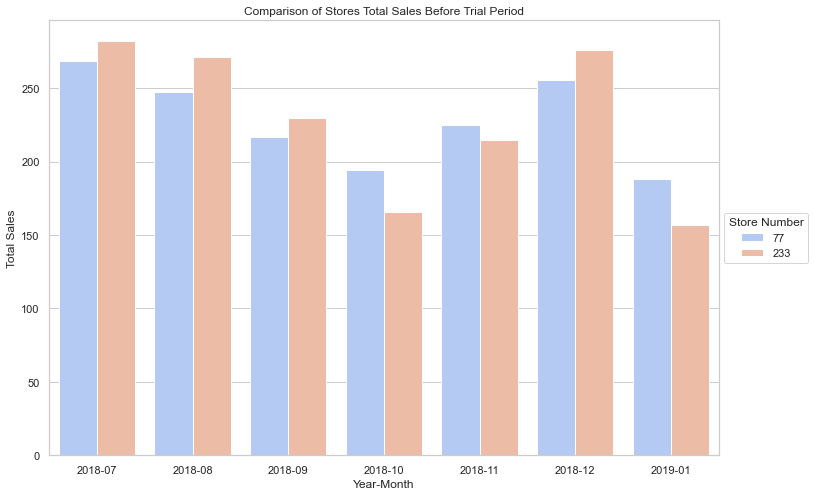

In [18]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_77_233_pre_trial,x='year-month',y='TOT_SALES',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=sum)

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Total Sales Before Trial Period');

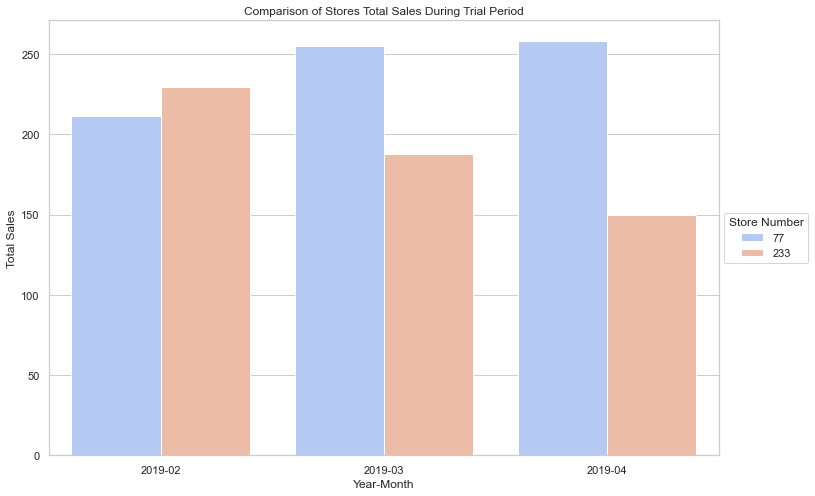

In [19]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_77_233_trial,x='year-month',y='TOT_SALES',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=sum)

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Total Sales During Trial Period');

In [55]:
scaled_compare_86_155_trial.pivot_table(values='TOT_SALES',columns='STORE_NBR',index='year-month',aggfunc={'TOT_SALES':'sum'})

STORE_NBR,86,155
year-month,,
2019-02,872.8,827.019610
2019-03,945.4,745.561872
2019-04,804.0,778.028321


We can check if the difference is statistically signifficant perfoming a t-test with a null hypothesis of there being 0 monthly total revenue difference between the trial and control stores for the trial periods.

In [20]:
stats.ttest_ind(scaled_compare_77_233_trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum').loc[77],
               scaled_compare_77_233_trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum').loc[233])

Ttest_indResult(statistic=1.9141052468050233, pvalue=0.12813840549898767)

The results show that the monthly total revenue during trial in store 77 is not significantly different to its control store in the trial period.

#### Comparing Number of Customers

Scaling number of customers

In [21]:
scaled_compare_77_233_pre_trial.loc[:,'LYLTY_CARD_NBR'] = scaled_compare_77_233_pre_trial.apply(scale_num_cust,axis=1)
scaled_compare_77_233_trial.loc[:,'LYLTY_CARD_NBR'] = scaled_compare_77_233_trial.apply(scale_num_cust,axis=1)

Graphical Analysis

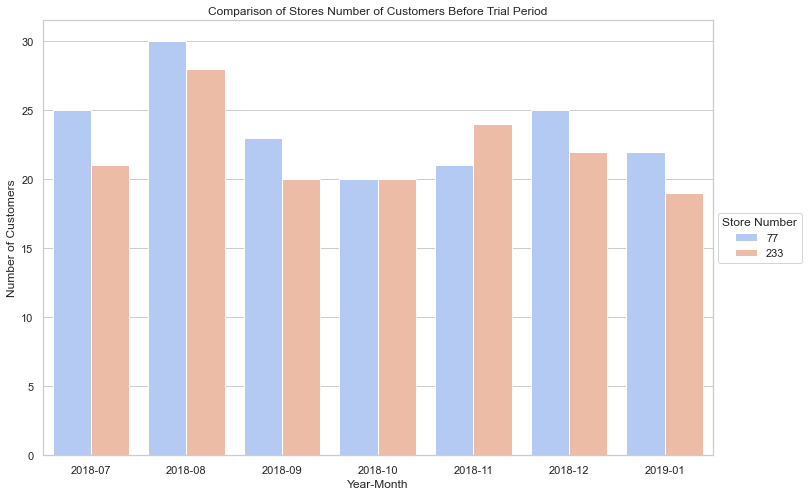

In [22]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_77_233_pre_trial,x='year-month',y='LYLTY_CARD_NBR',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=pd.Series.nunique)

plt.xlabel('Year-Month')
plt.ylabel('Number of Customers')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Number of Customers Before Trial Period');

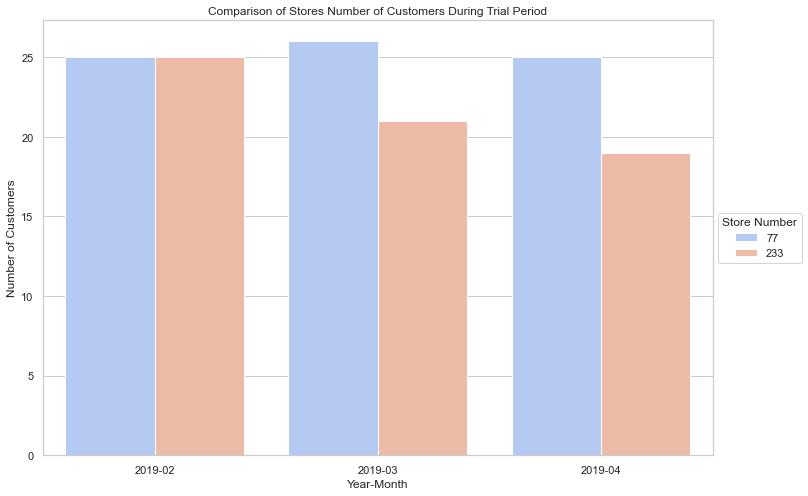

In [23]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_77_233_trial,x='year-month',y='LYLTY_CARD_NBR',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=pd.Series.nunique)

plt.xlabel('Year-Month')
plt.ylabel('Number of Customers')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Number of Customers During Trial Period');

 We will now test with a null hypothesis of there being 0 number of customers difference between the trial and the control store for the trial period.

In [24]:
stats.ttest_ind(scaled_compare_77_233_trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique).loc[77],
               scaled_compare_77_233_trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique).loc[233])

Ttest_indResult(statistic=2.0426487199475694, pvalue=0.11061012278987672)

The results show that there's no significantly number of customers difference between the trial in store 77 and control store in the trial period.

## Store 86 and Store 155

In [25]:
scaled_compare_86_155_pre_trial = pre_trial_df.query('STORE_NBR == 86 or STORE_NBR == 155').copy()
scaled_compare_86_155_trial = trial_df.query('STORE_NBR == 86 or STORE_NBR == 155').copy()
scaled_compare_86_155_pre_trial.loc[:,'TOT_SALES'] = scaled_compare_86_155_pre_trial.apply(scale_total_sales,axis=1)
scaled_compare_86_155_trial.loc[:,'TOT_SALES'] = scaled_compare_86_155_trial.apply(scale_total_sales,axis=1)

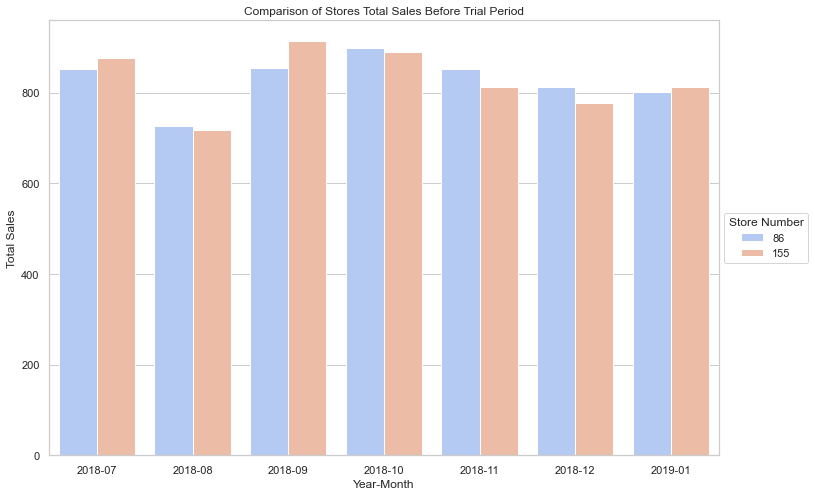

In [26]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_86_155_pre_trial,x='year-month',y='TOT_SALES',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=sum)

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Total Sales Before Trial Period');

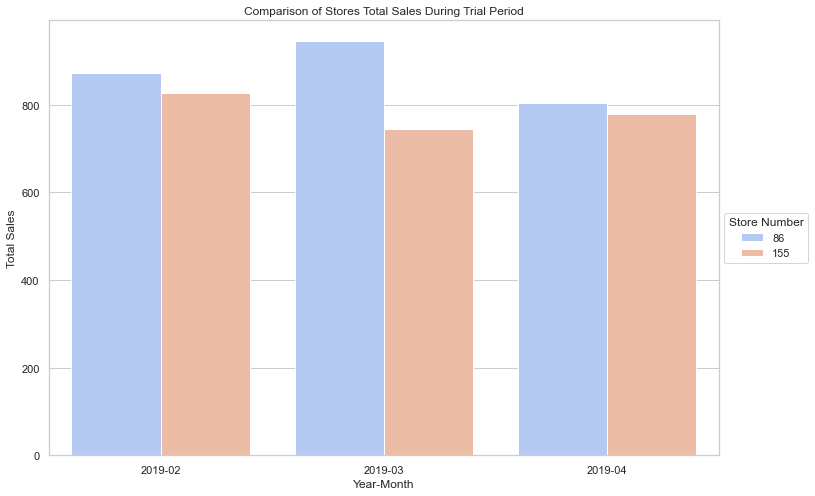

In [27]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_86_155_trial,x='year-month',y='TOT_SALES',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=sum)

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Total Sales During Trial Period');

We can check if the difference is statistically signifficant perfoming a t-test with a null hypothesis of there being 0 monthly total revenue difference between the trial and control stores for the trial periods.

In [28]:
stats.ttest_ind(scaled_compare_86_155_trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum').loc[86],
               scaled_compare_86_155_trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum').loc[155])

Ttest_indResult(statistic=1.918329928839408, pvalue=0.1275164635243009)

The results show that there's no significantly total revenue difference between the trial in store 86 and the control store in the trial period.

#### Comparing Number of Customers

In [29]:
scaled_compare_86_155_pre_trial.loc[:,'LYLTY_CARD_NBR'] = scaled_compare_86_155_pre_trial.apply(scale_num_cust,axis=1)
scaled_compare_86_155_trial.loc[:,'LYLTY_CARD_NBR'] = scaled_compare_86_155_trial.apply(scale_num_cust,axis=1)

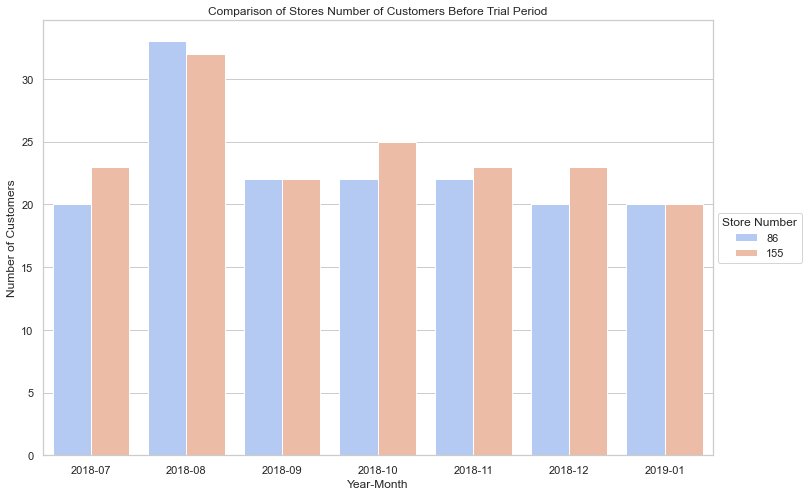

In [30]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_86_155_pre_trial,x='year-month',y='LYLTY_CARD_NBR',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=pd.Series.nunique)

plt.xlabel('Year-Month')
plt.ylabel('Number of Customers')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Number of Customers Before Trial Period');

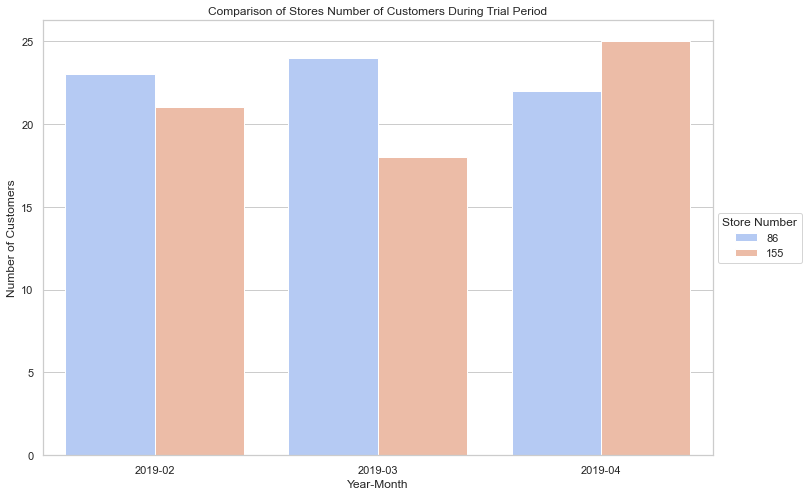

In [31]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_86_155_trial,x='year-month',y='LYLTY_CARD_NBR',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=pd.Series.nunique)

plt.xlabel('Year-Month')
plt.ylabel('Number of Customers')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Number of Customers During Trial Period');

In [32]:
stats.ttest_ind(scaled_compare_86_155_trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique).loc[86],
               scaled_compare_86_155_trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique).loc[155])

Ttest_indResult(statistic=0.7905694150420953, pvalue=0.4734273652571372)

The results show that there's no significantly number of customers difference between the trial in store 77 and control store in the trial period.

## Store 88 and Store 14

In [33]:
scaled_compare_88_14_pre_trial = pre_trial_df.query('STORE_NBR == 88 or STORE_NBR == 14').copy()
scaled_compare_88_14_trial = trial_df.query('STORE_NBR == 88 or STORE_NBR == 14').copy()
scaled_compare_88_14_pre_trial.loc[:,'TOT_SALES'] = scaled_compare_88_14_pre_trial.apply(scale_total_sales,axis=1)
scaled_compare_88_14_trial.loc[:,'TOT_SALES'] = scaled_compare_88_14_trial.apply(scale_total_sales,axis=1)

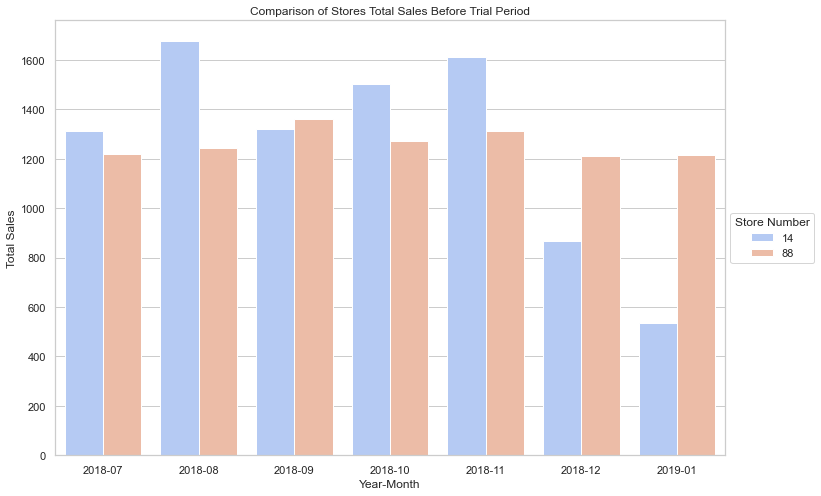

In [34]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_88_14_pre_trial,x='year-month',y='TOT_SALES',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=sum)

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Total Sales Before Trial Period');

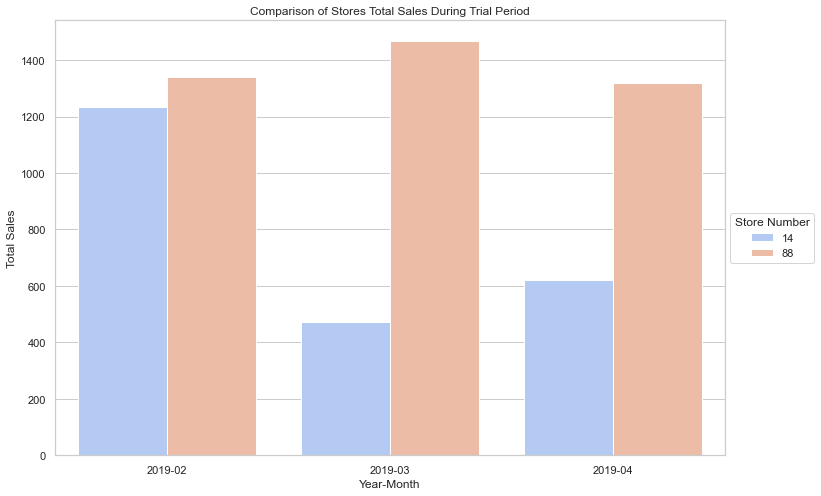

In [35]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_88_14_trial,x='year-month',y='TOT_SALES',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=sum)

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Total Sales During Trial Period');

In [36]:
stats.ttest_ind(scaled_compare_88_14_pre_trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum').loc[88],
               scaled_compare_88_14_trial.pivot_table(values='TOT_SALES',columns=['year','month'],index='STORE_NBR',aggfunc='sum').loc[14])

Ttest_indResult(statistic=3.4040222383372685, pvalue=0.00930497392292769)

The results show that the monthly total revenue during trial in store 88 is significantly different to its control store in the trial period.

#### Comparing Number of Customers

In [37]:
scaled_compare_88_14_pre_trial.loc[:,'LYLTY_CARD_NBR'] = scaled_compare_88_14_pre_trial.apply(scale_num_cust,axis=1)
scaled_compare_88_14_trial.loc[:,'LYLTY_CARD_NBR'] = scaled_compare_88_14_trial.apply(scale_num_cust,axis=1)

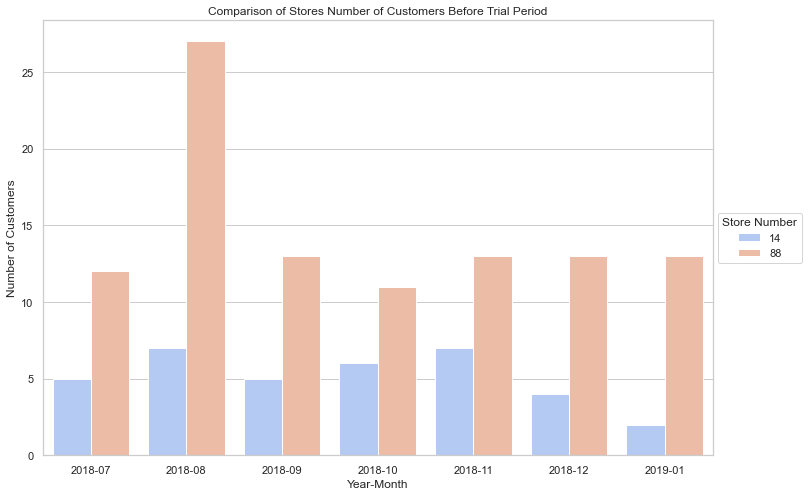

In [38]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_88_14_pre_trial,x='year-month',y='LYLTY_CARD_NBR',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=pd.Series.nunique)

plt.xlabel('Year-Month')
plt.ylabel('Number of Customers')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Number of Customers Before Trial Period');

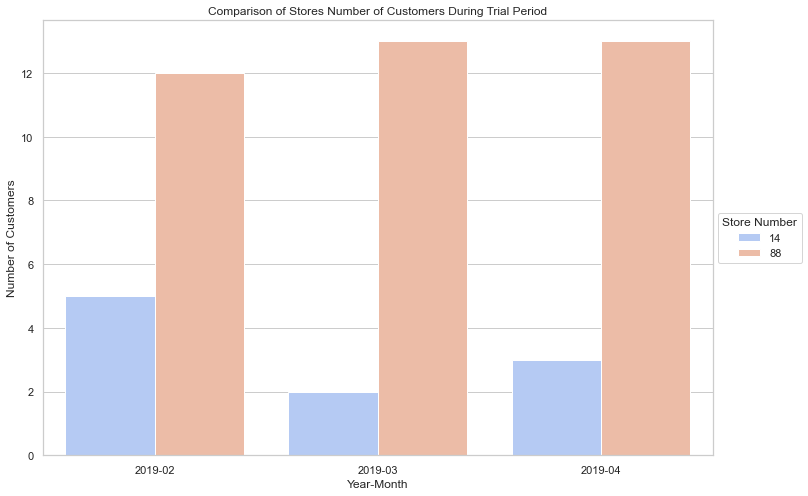

In [39]:
plt.figure(figsize=(12,8)) 

sns.barplot(data=scaled_compare_88_14_trial,x='year-month',y='LYLTY_CARD_NBR',hue='STORE_NBR',ci=None,palette='coolwarm',estimator=pd.Series.nunique)

plt.xlabel('Year-Month')
plt.ylabel('Number of Customers')
plt.legend(title='Store Number',loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Comparison of Stores Number of Customers During Trial Period');

In [40]:
stats.ttest_ind(scaled_compare_88_14_trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique).loc[88],
               scaled_compare_88_14_trial.pivot_table(values='LYLTY_CARD_NBR',columns=['year','month'],index='STORE_NBR',aggfunc=pd.Series.nunique).loc[14])

Ttest_indResult(statistic=9.899494936611664, pvalue=0.0005844106153028071)

The results show that the number of customers difference during trial in store 88 is significantly different to its control store in the trial period.

# Conclusion

We' ve found control stores 233, 155, 14 for trial stores 77, 86 and 88 respectively.  The results for trial stores 77 and 86 during the trial period don't show a significant difference in at least two of the three trial months but this is not the case for trial store 88. We can check with the client if the implementation of the trial wasdifferent in trial store 88 but overall, the trial doesn't shows a significant increase in sales.